In [12]:
import yfinance as yf
import pandas as pd

# 下載NVDA的股票數據
nvda = yf.Ticker("NVDA")
nvda_history = nvda.history(period="5y")

# 保存數據到CSV文件
csv_path = "nvda_stock_data.csv"
nvda_history[['Close']].to_csv(csv_path, index=True, index_label='Date')

print(f"CSV文件已生成：{csv_path}")

CSV文件已生成：nvda_stock_data.csv


946/946 [==============================] - 17s 15ms/step - loss: 3.2729e-04
x_test shape: (192, 60, 1)
6/6 [==============================] - 1s 12ms/step


C:\Users\jk121\AppData\Local\Temp\ipykernel_27080\206191517.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


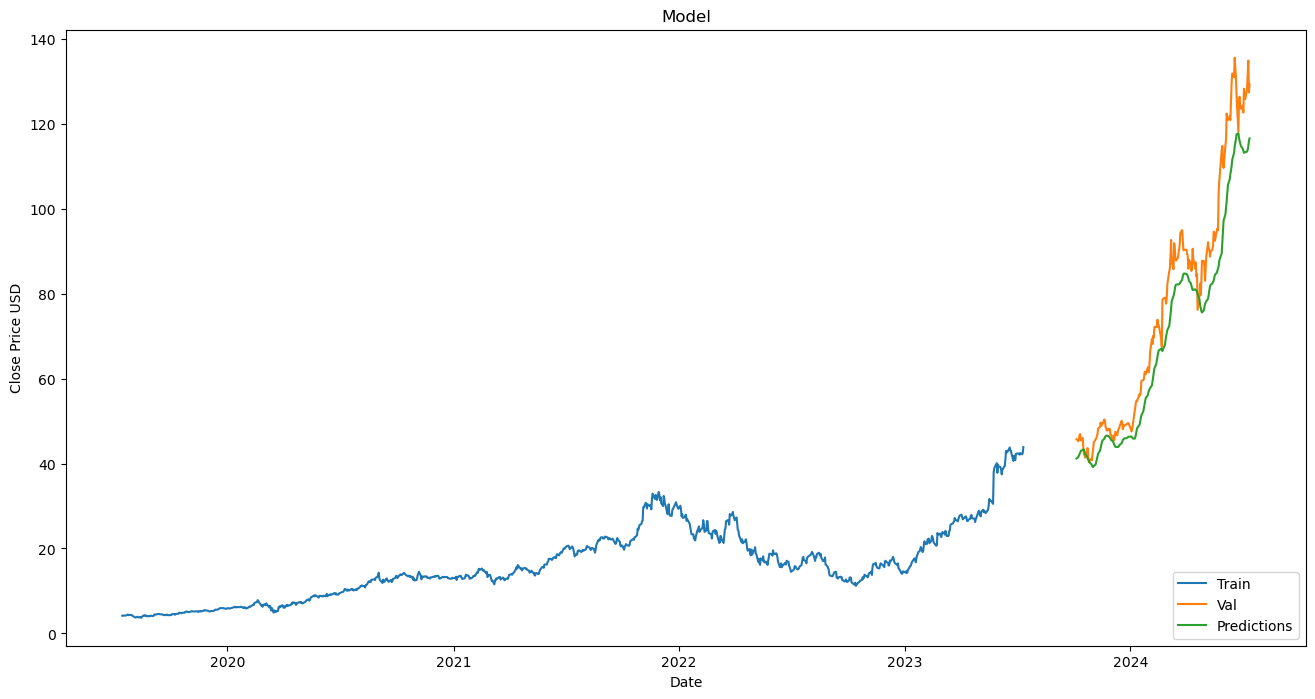

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 讀取數據
data = pd.read_csv('nvda_stock_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

# 數據預處理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 生成訓練和測試數據集
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]

# 確保訓練數據至少有250條
required_train_samples = 250
time_steps = 60

if len(train_data) < (required_train_samples + time_steps):
    raise ValueError(f"Not enough training data. At least {required_train_samples + time_steps} data points are required.")

x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 構建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 編譯和訓練模型
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# 準備測試數據集
x_test = []
y_test = test_data[time_steps:]  # 確保 y_test 的索引對應 x_test

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i])

x_test = np.array(x_test)

# 檢查 x_test 的形狀
print(f"x_test shape: {x_test.shape}")

# 檢查 x_test 是否為空
if x_test.size == 0:
    print("x_test is empty, check the test_data length and indices.")
else:
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # 預測股價
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # 可視化結果
    train = data[:train_data_len]
    # 調整 valid DataFrame 以與預測對齊
    valid = data[train_data_len + time_steps:]  # 從訓練數據結束後的 time_steps 開始
    valid['Predictions'] = predictions

    # 現在繪製結果
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD')
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()